# Experiments ESA HST Archhive Data Set - Clustering vs. Mean Value Threshold


This noteboook contains the code executed various experiments to show the general problem of the score inflation of the SSIM, and the rapidly decreasing value for pixel values close to 0. Additionally, experiments were performed on the ESA HST Archive Data Set to showcase the effects of different image alterations on the entire images and on the detailed regions of the images only. To detect the detailed regions of the images, both the clustering and the mean value threshold methods were implemented.

In [1]:
from PIL import Image, ImageStat, ImageEnhance
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from scipy.ndimage.filters import gaussian_filter
from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt
import glob 
import random
import numpy as np
import os
import cv2
import argparse
import pandas as pd
import math
import torch  
import torch.nn.functional as F 

## Selective SSIM Implementation 

In [2]:
# turn 3d numpy array into pytorch tensor
make_tensor = lambda x: torch.Tensor(x.transpose((2, 0, 1))).unsqueeze(0).float().div(255.0)

def sssim_func(img1, img2, val_range, weighted_array, window_size=11, k1=0.01, k2=0.03, sigma=1.5):
    
    if img1.shape != img2.shape:
        print("ValueError: differently sized input images")
        return None
    
    if window_size % 2 == 0:
        print("ValueError: window size is not odd")
        return None
        
    try:
        _, img_channels, height, width = img1.size()
    except:
        img_channels, height, width = img1.size()
    
    # we set L to be the dynamic range of pixel values
    L = val_range 
    # we define the padding size for the sliding window
    pad = window_size // 2
    
    # initialize sliding window
    # 1d tensor
    window_1d = torch.Tensor(np.exp(-(np.arange(window_size) - window_size//2)**2/float(2*sigma**2)))
    window_1d /= window_1d.sum()
    window_1d = window_1d.unsqueeze(1)

    # convert to 2d
    window_2d = torch.Tensor(np.outer(window_1d, window_1d)).unsqueeze(0).unsqueeze(0)
    
    window = torch.Tensor(window_2d.expand(img_channels, 1, window_size, window_size).contiguous())
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=img_channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=img_channels)

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=img_channels) - mu1**2
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=img_channels) - mu2**2
    sigma_12 =  F.conv2d(img1 * img2, window, padding=pad, groups=img_channels) - mu1*mu2

    # Define stability constants
    C1 = k1 ** 2  
    C2 = k2 ** 2 

    num1 = 2 * mu1*mu2 + C1  
    num2 = 2 * sigma_12 + C2
    denom1 = mu1**2 + mu2**2 + C1 
    denom2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (num1 * num2) / (denom1 * denom2)    
    weighted_ssim_score = weighted_array * ssim_score

    return torch.sum(weighted_ssim_score) / torch.sum(weighted_array)


## Show Problem 

In [3]:
# function that creates simple box image with varying size of box
def create_box_image(box_size, pixel_val):
    width = 250
    height = 250
    box_width = int(box_size * width)
    box_height = int(box_size * height)
    im_array = np.zeros((height, width))
    box_im_array = pixel_val * np.ones((box_height, box_width))
    if box_width % 2 == 0:
        im_array[height//2-box_height//2:height//2+box_height//2, width//2-box_width//2:width//2+box_width//2] = box_im_array
    else:
        im_array[height//2-box_height//2:height//2+box_height//2+1, width//2-box_width//2:width//2+box_width//2+1] = box_im_array
    return im_array

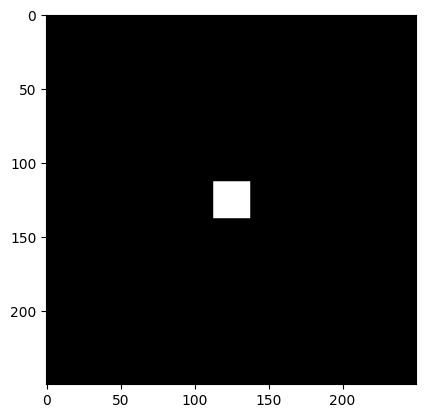

In [4]:
plt.imshow(create_box_image(0.1,pixel_val=100),cmap='gray')

We show the development of SSIM score with increasing area of different pixels by comparing the box image to a completely black image.

In [5]:
width = 250
height = 250
img_array = np.zeros((height, width))
ssim_vals = []
for i in range(101):
    box_size = i/100
    compare_img = create_box_image(box_size, pixel_val=255)
    ssim_vals.append(ssim(img_array, compare_img, data_range=255))
    

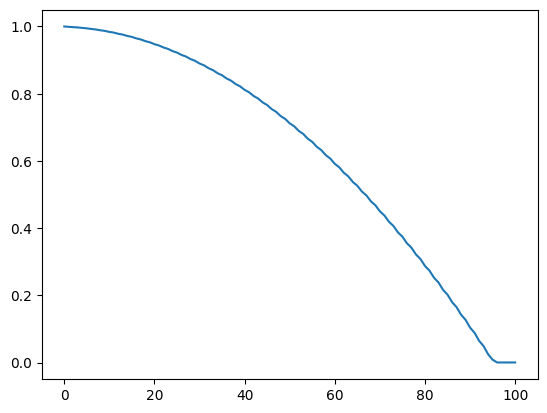

In [6]:
percentages = list(range(101))
plt.plot(percentages, ssim_vals)

We show the same with an increasing box with stripes inside. 

In [7]:
def create_box_stripe_image(box_size, pixel_val, stripe_val):
    width = 250
    height = 250
    box_width = int(box_size * width)
    box_height = int(box_size * height)
    im_array = np.zeros((height, width))
    box_im_array = pixel_val * np.ones((box_height, box_width))
    no_stripes = int(box_size * 30)
    if no_stripes < 1:
        box_im_array = box_im_array
    else:
        stripe_nodes = int(box_width // no_stripes)
        for i in range(no_stripes+1):
            box_im_array[:,i*stripe_nodes:i*stripe_nodes+2] = box_im_array[:,i*stripe_nodes:i*stripe_nodes+2] - stripe_val
    if box_width % 2 == 0:
        im_array[height//2-box_height//2:height//2+box_height//2, width//2-box_width//2:width//2+box_width//2] = box_im_array
    else:
        im_array[height//2-box_height//2:height//2+box_height//2+1, width//2-box_width//2:width//2+box_width//2+1] = box_im_array
    return im_array

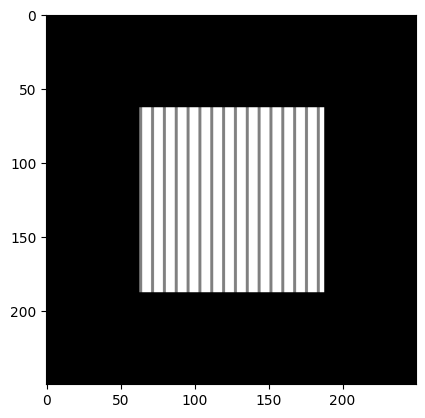

In [8]:
plt.imshow(create_box_stripe_image(0.5,100,50), cmap='gray')

/home/julia/galaxies/lib/python3.8/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


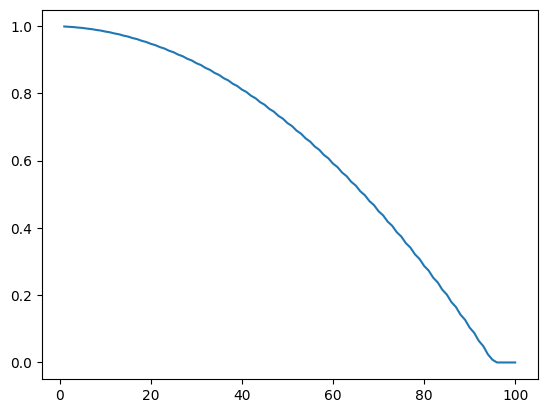

In [9]:
width = 250
height = 250
img_array = np.zeros((height, width))
ssim_vals = []
for i in range(101):
    box_size = i/100
    compare_img = create_box_stripe_image(box_size, pixel_val=255,stripe_val=155)
    ssim_vals.append(ssim(img_array, compare_img, data_range=compare_img.max()-compare_img.min()))
percentages = list(range(101))
plt.plot(percentages, ssim_vals)

## Perform Image Transformations

### Blurring

We first write a function that creates a black image with a striped box of varying size and applies blur only to the box area.

In [4]:
def create_blurred_box(box_size, sigma, pixel_val, stripe_val):
    width = 250
    height = 250
    box_width = int(box_size * width)
    box_height = int(box_size * height)
    im_array = np.zeros((height, width))
    box_im_array = pixel_val * np.ones((box_height, box_width))
    no_stripes = int(box_size * 30)
    if no_stripes < 1:
        box_im_array = box_im_array
    else:
        stripe_nodes = int(box_width // no_stripes)
        for i in range(no_stripes+1):
            box_im_array[:,i*stripe_nodes:i*stripe_nodes+2] = box_im_array[:,i*stripe_nodes:i*stripe_nodes+2] - stripe_val
    # apply Gaussian blur
    box_im_array = gaussian_filter(box_im_array, sigma=sigma) 
    if box_width % 2 == 0:
        im_array[height//2-box_height//2:height//2+box_height//2, width//2-box_width//2:width//2+box_width//2] = box_im_array
    else:
        im_array[height//2-box_height//2:height//2+box_height//2+1, width//2-box_width//2:width//2+box_width//2+1] = box_im_array
    return im_array

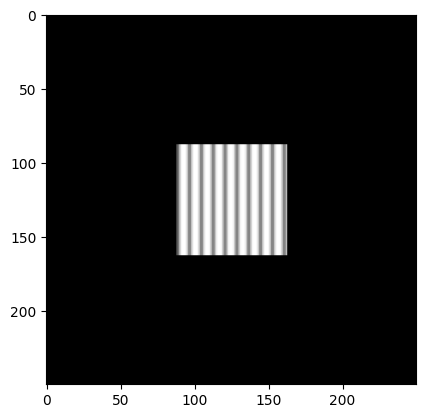

In [12]:
plt.imshow(create_blurred_box(0.3,1,200,150),cmap='gray')

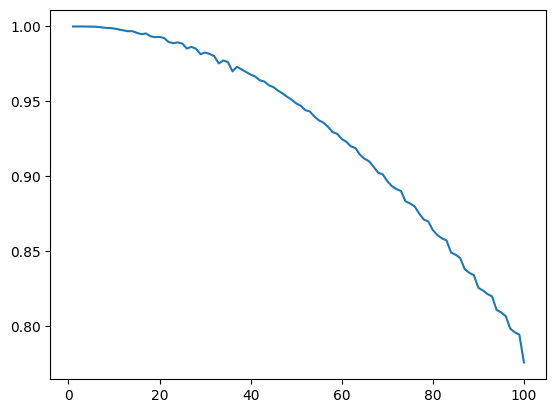

In [13]:
# compare blurred box image (sigma=1) with completely black image, size of box increasing from 0-100%
width = 250
height = 250
ssim_vals = []
for i in range(101):
    box_size = i/100
    img_array = create_box_stripe_image(box_size, pixel_val=150, stripe_val=50)
    compare_img = create_blurred_box(box_size, sigma=1, pixel_val=150, stripe_val=50)
    ssim_vals.append(ssim(img_array, compare_img, data_range=compare_img.max()-compare_img.min()))
percentages = list(range(101))
plt.plot(percentages, ssim_vals)

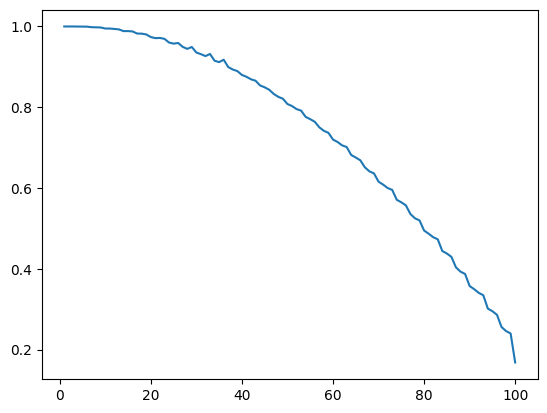

In [15]:
# compare blurred box image (sigma=2.5) with completely black image, size of box increasing from 0-100%

width = 250
height = 250
ssim_vals = []
for i in range(101):
    box_size = i/100
    img_array = create_box_stripe_image(box_size, pixel_val=150, stripe_val=50)
    compare_img = create_blurred_box(box_size, sigma=2.5, pixel_val=150, stripe_val=50)
    ssim_vals.append(ssim(img_array, compare_img, data_range=compare_img.max()-compare_img.min()))
percentages = list(range(101))
plt.plot(percentages, ssim_vals)

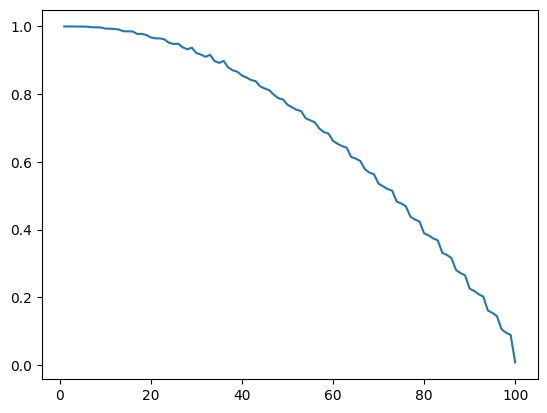

In [16]:
# compare blurred box image (sigma=20) with completely black image, size of box increasing from 0-100%
width = 250
height = 250
ssim_vals = []
for i in range(101):
    box_size = i/100
    img_array = create_box_stripe_image(box_size, pixel_val=150, stripe_val=50)
    compare_img = create_blurred_box(box_size, sigma=20, pixel_val=150, stripe_val=50)
    ssim_vals.append(ssim(img_array, compare_img, data_range=compare_img.max()-compare_img.min()))
percentages = list(range(101))
plt.plot(percentages, ssim_vals)

### Blurring Distribution



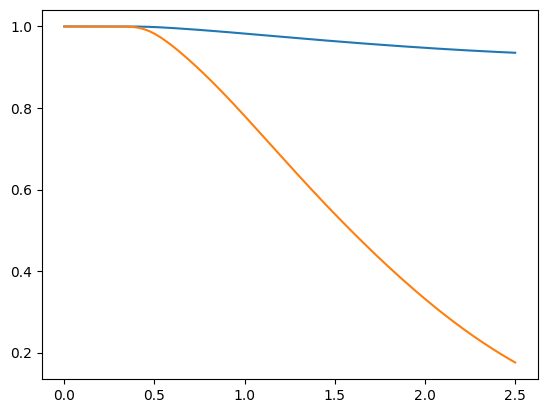

In [17]:
# we fix the size of the box to be 30% of the image and increase the blur applied to the box area by ranging the
# SD of the Gaussian blur from 0 to 100, and compare the image with a completely dark image
width = 250
height = 250
box_width = int(0.3 * width)
box_height = int(0.3 * height)
ssim_vals = []
sssim_vals = []
gaussian_blur = np.linspace(0,2.5,150)
box_size=0.3
for blur in gaussian_blur:
    img_array = create_box_stripe_image(box_size, pixel_val=150, stripe_val=50)
    compare_img = create_blurred_box(box_size, sigma=blur, pixel_val=150, stripe_val=50)
    ssim_vals.append(ssim(img_array, compare_img, data_range=compare_img.max()-compare_img.min()))
    
    # create image array for box only 
    box_im_array = 150 * np.ones((box_height, box_width))
    no_stripes = int(box_size * 30)
    if no_stripes < 1:
        box_im_array = box_im_array
    else:
        stripe_nodes = int(box_width // no_stripes)
        for i in range(no_stripes+1):
            box_im_array[:,i*stripe_nodes:i*stripe_nodes+2] = box_im_array[:,i*stripe_nodes:i*stripe_nodes+2] - 50
    # apply Gaussian blur
    box_im_array_blurred = gaussian_filter(box_im_array, sigma=blur) 
    sssim_vals.append(ssim(box_im_array, box_im_array_blurred, data_range=box_im_array_blurred.max()-box_im_array_blurred.min()))

plt.plot(gaussian_blur, ssim_vals)
plt.plot(gaussian_blur, sssim_vals)

### Adding Noise Distribution

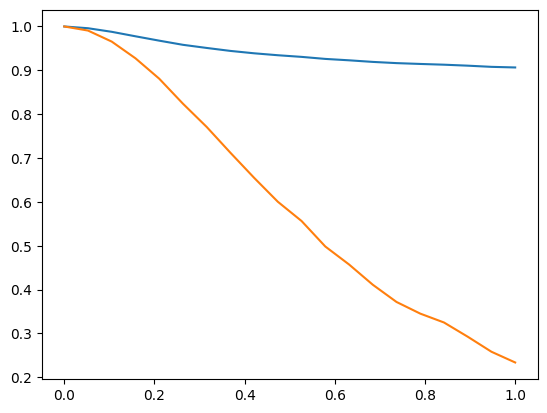

In [18]:
# we fix the size of the box to be 30% of the image and increase the noise applied to the box area by ranging the
# percentage of added noise to the image from 0 to 100%, and compare the image with a completely dark image
width = 250
height = 250
box_width = int(0.3 * width)
box_height = int(0.3 * height)
ssim_vals = []
sssim_vals = []
noise_vals = np.linspace(0,1,20)
box_size=0.3
for n in noise_vals:
    # create image array for box only 
    box_im_array = 150 * np.ones((box_height, box_width))
    no_stripes = int(box_size * 30)
    if no_stripes < 1:
        box_im_array = box_im_array
    else:
        stripe_nodes = int(box_width // no_stripes)
        for i in range(no_stripes+1):
            box_im_array[:,i*stripe_nodes:i*stripe_nodes+2] = box_im_array[:,i*stripe_nodes:i*stripe_nodes+2] - 50
    # create noise
    noise = np.zeros(box_im_array.shape)
    cv2.randn(noise, 256, 40)
    noise=noise*n                    
    box_im_array_noise=cv2.add(np.array(box_im_array),np.array(noise))
    sssim_vals.append(ssim(box_im_array, box_im_array_noise, data_range=box_im_array_noise.max()-box_im_array_noise.min()))
    
    # create full images
    im_array = 150 * np.ones((height, width))
    if box_width % 2 == 0:
        im_array[height//2-box_height//2:height//2+box_height//2, width//2-box_width//2:width//2+box_width//2] = box_im_array
    else:
        im_array[height//2-box_height//2:height//2+box_height//2+1, width//2-box_width//2:width//2+box_width//2+1] = box_im_array
    im_array_noise = 150 * np.ones((height, width))
    if box_width % 2 == 0:
        im_array_noise[height//2-box_height//2:height//2+box_height//2, width//2-box_width//2:width//2+box_width//2] = box_im_array_noise
    else:
        im_array_noise[height//2-box_height//2:height//2+box_height//2+1, width//2-box_width//2:width//2+box_width//2+1] = box_im_array_noise
    ssim_vals.append(ssim(im_array, im_array_noise, data_range=im_array_noise.max()-im_array_noise.min()))

plt.plot(noise_vals, ssim_vals)
plt.plot(noise_vals, sssim_vals)

### Sharpen Image

[1.0, 0.9998769609510545, 0.9996708461357209, 0.9993735395060468, 0.9989952782687253, 0.9985452952666392, 0.9980318448195903, 0.9974622896168718, 0.996843207210293, 0.9961804938861387, 0.9954794563146508, 0.9943698708356753, 0.9931921411234272, 0.9923814978604771, 0.9915524739292362, 0.9907080468761771, 0.9898509282224547, 0.9889835857791526, 0.9881082635191863, 0.9872269995049953, 0.9863416422248678, 0.9854538655884529, 0.9841492076944764, 0.9827904233570444, 0.9819066800359146, 0.9810267182739666, 0.9801514219993985, 0.9792815785909527, 0.9784178870238033, 0.9775609654074653, 0.97671135795389, 0.9758695414118413, 0.9750359310024419, 0.9738391589760477, 0.9725876777223477, 0.9717899960363776, 0.9710018505455605, 0.9702233880026091, 0.9694547238099462, 0.9686959450327336, 0.9679471131578717, 0.9672082666188048, 0.9664794231046165, 0.9657605816707253, 0.964739691292832, 0.9636638202320641, 0.9629846690611376, 0.9623152976423482, 0.9616556283120065, 0.961005575194359, 0.9603650452099939,

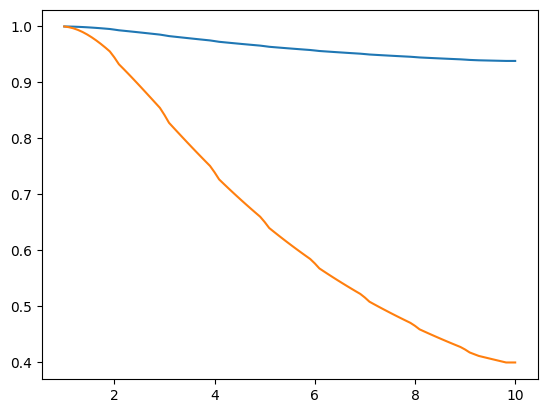

In [6]:
width = 250
height = 250
box_width = int(0.3 * width)
box_height = int(0.3 * height)
ssim_vals = []
sssim_vals = []
sharpness = np.linspace(1,10,100)
box_size=0.3

for s in sharpness:
    # create image array for box only 
    box_im_array = 150 * np.ones((box_height, box_width))
    no_stripes = int(box_size * 30)
    if no_stripes < 1:
        box_im_array = box_im_array
    else:
        stripe_nodes = int(box_width // no_stripes)
        for i in range(no_stripes+1):
            box_im_array[:,i*stripe_nodes:i*stripe_nodes+2] = box_im_array[:,i*stripe_nodes:i*stripe_nodes+2] - 50
    factor = s
    im = Image.fromarray(np.uint8(box_im_array * 255) , 'L')
    box_im_array = np.array(im)
    enhancer = ImageEnhance.Sharpness(im)
    sharpened_box_im = enhancer.enhance(factor)
    sharpened_box_im = np.array(sharpened_box_im)
    #sharpened_box_im = unsharp_mask(box_im_array, amount=s)
    
    sssim_vals.append(ssim(box_im_array, sharpened_box_im, data_range=sharpened_box_im.max()-sharpened_box_im.min()))
    
    # create full images
    im_array = 150 * np.ones((height, width))
    if box_width % 2 == 0:
        im_array[height//2-box_height//2:height//2+box_height//2, width//2-box_width//2:width//2+box_width//2] = box_im_array
    else:
        im_array[height//2-box_height//2:height//2+box_height//2+1, width//2-box_width//2:width//2+box_width//2+1] = box_im_array
    im_array_sharp = 150 * np.ones((height, width))
    if box_width % 2 == 0:
        im_array_sharp[height//2-box_height//2:height//2+box_height//2, width//2-box_width//2:width//2+box_width//2] = sharpened_box_im
    else:
        im_array_sharp[height//2-box_height//2:height//2+box_height//2+1, width//2-box_width//2:width//2+box_width//2+1] = sharpened_box_im
    ssim_vals.append(ssim(im_array, im_array_sharp, data_range=im_array_sharp.max()-im_array_sharp.min()))

plt.plot(sharpness, ssim_vals)
plt.plot(sharpness, sssim_vals)

ssim_sharpened_dist_df = pd.DataFrame(ssim_vals)
print(ssim_vals)
ssim_sharpened_dist_df.to_csv('sharpening_dist_ssim.csv') 

sssim_sharpened_dist_df = pd.DataFrame(sssim_vals)
sssim_sharpened_dist_df.to_csv('sharpening_dist_sssim.csv') 



### Comparison Black and White images

Experiment recreated from Nilsson et al., Understanding SSIM (https://arxiv.org/abs/2006.13846)

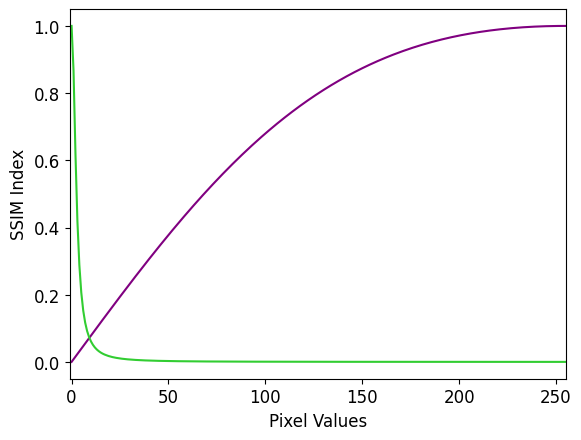

In [16]:
height = 250
width = 250 
img_white = 255 * np.ones((height,width))
img_black = np.zeros((height, width))

pixel_vals = list(range(256))

ssim_vals_white = []
ssim_vals_black = []

for i in range(256):
    compare_im_white = i*np.ones((height, width))
    compare_im_black = i*np.ones((height,width))
    ssim_vals_white.append(ssim(img_white, compare_im_white, data_range=255))
    ssim_vals_black.append(ssim(img_black, compare_im_black, data_range=255))
plt.figure()
plt.plot(pixel_vals, ssim_vals_white, color='purple')
plt.plot(pixel_vals, ssim_vals_black, color='limegreen')
plt.xlim(xmin=-1, xmax=255)
plt.ylim(ymin=-0.05, ymax=1.05)
plt.xlabel("Pixel Values", fontsize=12)
plt.ylabel("SSIM Index", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("black_white_exp.png")

## Background Detection on RGB Data Set - Clustering


### Show portions of background created through method

In [3]:
ind = 0
background_percentage = []

for filename in glob.glob('/home/julia/temp/*.tif'):
    print(ind)
    
    # load image
    im=Image.open(filename)
    # convert image to numpy array
    imarray = np.array(im)
    
    # create array that has brightness value for each pixel 
    rgb_array = np.sqrt(0.299*imarray[:,:,0]*imarray[:,:,0] + 0.587*imarray[:,:,1]*imarray[:,:,1] + 0.114*imarray[:,:,2]*imarray[:,:,2])
    data = rgb_array.flatten()
    data = data.reshape(-1,1)
    kmeans = KMeans(n_clusters=3, n_init=10)
    kmeans.fit(data)
    df = pd.DataFrame({'brightness': rgb_array.flatten(),
                           'label': kmeans.labels_})
    
    background_label = df.loc[df['brightness'].idxmin()]['label']
    data = data.reshape(rgb_array.shape)
    labels = kmeans.labels_.reshape(rgb_array.shape[0],rgb_array.shape[1])
    background_array = 1 * (labels == background_label)
    background_array = background_array.reshape(background_array.shape[0], background_array.shape[1], 1)
    detailed_array = 1*(labels != background_label)
    detailed_array = detailed_array.reshape(detailed_array.shape[0], detailed_array.shape[1], 1)
    weighted_array = detailed_array*np.ones((detailed_array.shape[0], detailed_array.shape[1], 3))

    background_portion = np.count_nonzero(background_array)
    detailed_portion = np.count_nonzero(detailed_array)
    background_percentage.append(background_portion/(background_portion+detailed_portion))
    ind += 1
    
print(np.mean(background_percentage))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Blurring

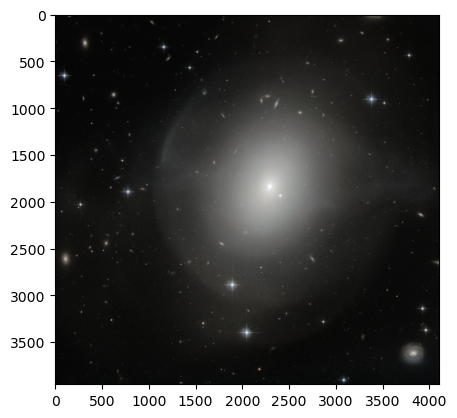

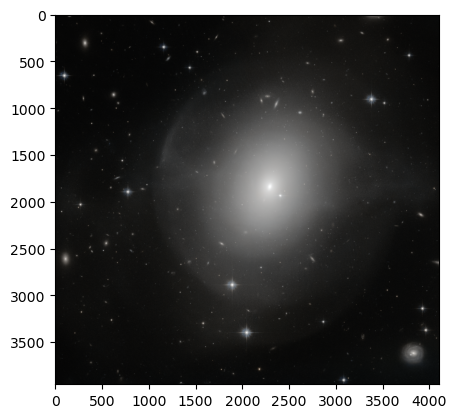

SSIM value:  0.9276798146442712
Selecive SSIM value:  tensor(0.8255)


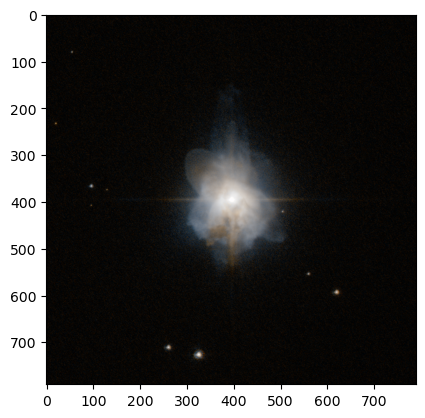

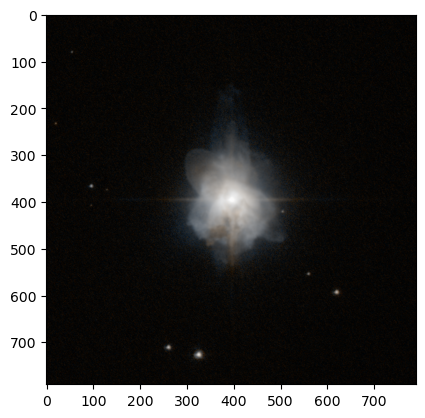

SSIM value:  0.9920971718423028
Selecive SSIM value:  tensor(0.9096)


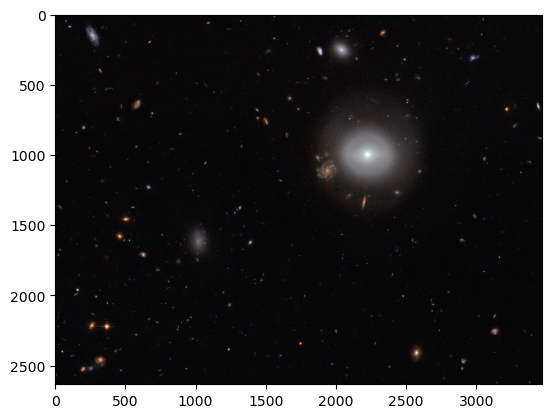

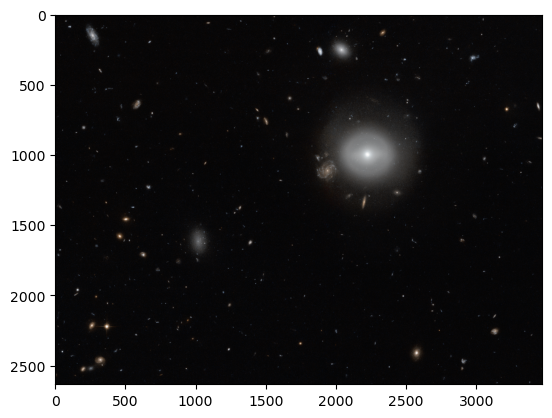

SSIM value:  0.9396367074743667
Selecive SSIM value:  tensor(0.7840)
Comparison color images:
Max SSIM difference:  0.35308416001500287
Mean SSIM difference:  0.13750623108632384
Distribution of SSIM values:
Max SSIM value:  0.9988563358863337
Min SSIM value:  0.7416049916358035
Mean SSIM value:  0.958612424186149
Distribution of SSSIM values:
Max SSSIM value:  0.9861331
Min SSSIM value:  0.5068549
Mean SSSIM value:  0.8211062


Text(0.5, 1.0, 'Histogram of SSSIM index values')

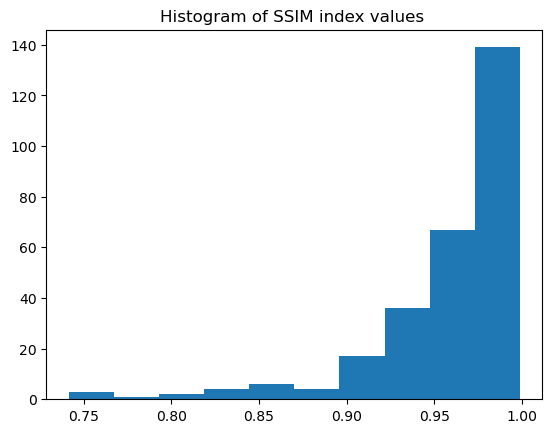

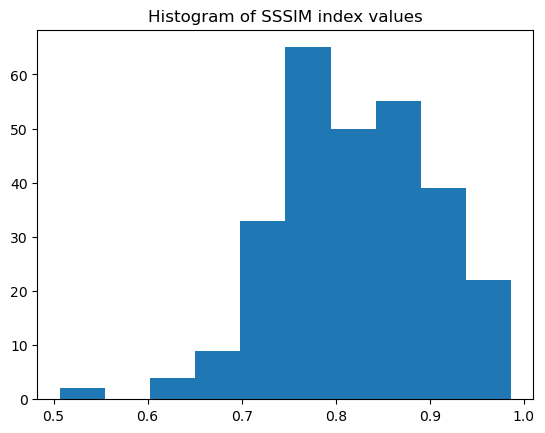

In [117]:
# compare ssim values

ind = 0

example_files = ['potw2303a.tif', 'heic1507h.tif', 'potw2236a.tif']
ssim_vals_full = []
ssim_vals_selected = []

for filename in glob.glob('/home/julia/*.tif'):
    # load image
    im=Image.open(filename)
    # convert image to numpy array
    imarray = np.array(im)
    
    # create array that has brightness value for each pixel 
    rgb_array = np.sqrt(0.299*imarray[:,:,0]*imarray[:,:,0] + 0.587*imarray[:,:,1]*imarray[:,:,1] + 0.114*imarray[:,:,2]*imarray[:,:,2])
    data = rgb_array.flatten()
    data = data.reshape(-1,1)
    kmeans = KMeans(n_clusters=3, n_init=10)
    kmeans.fit(data)
    df = pd.DataFrame({'brightness': rgb_array.flatten(),
                           'label': kmeans.labels_})
    
    background_label = df.loc[df['brightness'].idxmin()]['label']
    data = data.reshape(rgb_array.shape)
    labels = kmeans.labels_.reshape(rgb_array.shape[0],rgb_array.shape[1])
    background_array = 1 * (labels == background_label)
    background_array = background_array.reshape(background_array.shape[0], background_array.shape[1], 1)
    detailed_array = 1*(labels != background_label)
    detailed_array = detailed_array.reshape(detailed_array.shape[0], detailed_array.shape[1], 1)
    weighted_array = detailed_array*np.ones((detailed_array.shape[0], detailed_array.shape[1], 3))

    # create blurred image in detailed areas 
    blurred = gaussian_filter(imarray, sigma=1) * detailed_array + imarray * background_array

    # calculate different ssim scores
    ssim_val_selected = sssim_func(make_tensor(imarray), 
                             make_tensor(blurred), 
                             val_range=255, 
                             weighted_array=make_tensor(weighted_array))
    ssim_val = ssim(imarray, blurred, data_range=blurred.max()-blurred.min(), channel_axis=2)
    
    if ind in [23, 95, 123]:
        plt.figure()
        plt.imshow(imarray)
        plt.show()
        plt.figure()
        plt.imshow(blurred)
        plt.show()

        print("SSIM value: ", ssim_val)
        print("Selecive SSIM value: ", ssim_val_selected)

    
    ssim_vals_full.append(ssim_val)
    ssim_vals_selected.append(ssim_val_selected)
    
    ind += 1

print("Comparison color images:")
print("Max SSIM difference: ", np.max(np.array(ssim_vals_full)-np.array(ssim_vals_selected)))
print("Mean SSIM difference: ", np.mean(np.array(ssim_vals_full)-np.array(ssim_vals_selected)))

print("Distribution of SSIM values:")
print("Max SSIM value: ", np.max(ssim_vals_full))
print("Min SSIM value: ", np.min(ssim_vals_full))
print("Mean SSIM value: ", np.mean(ssim_vals_full))

print("Distribution of SSSIM values:")
print("Max SSSIM value: ", np.max(ssim_vals_selected))
print("Min SSSIM value: ", np.min(ssim_vals_selected))
print("Mean SSSIM value: ", np.mean(ssim_vals_selected))

plt.figure()
plt.hist(ssim_vals_full)
plt.title("Histogram of SSIM index values ")

plt.figure()
plt.hist(ssim_vals_selected)
plt.title("Histogram of SSSIM index values")


In [119]:
# save values in csv files
ssim_blurred_df = pd.DataFrame(ssim_vals_full)
ssim_blurred_df.to_csv('ssim_blurred.csv') 
sssim_blurred_df = pd.DataFrame(ssim_vals_selected)
sssim_blurred_df.to_csv('sssim_blurred.csv') 

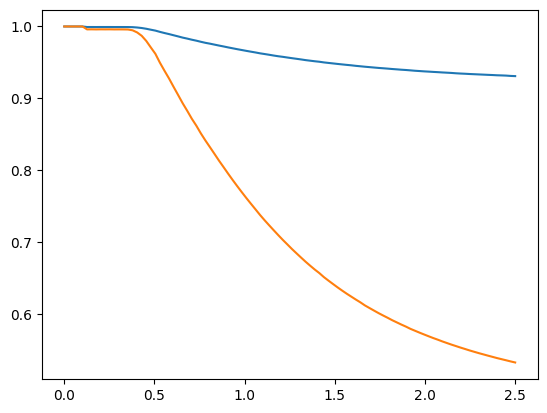

In [24]:
filename = '/home/julia/potw2303a.tif'

ssim_vals = []
sssim_vals = []

gaussian_blur = np.linspace(0,2.5,100)


# load image
im=Image.open(filename)
# convert image to numpy array
imarray = np.array(im)

# create array that has brightness value for each pixel 
rgb_array = np.sqrt(0.299*imarray[:,:,0]*imarray[:,:,0] + 0.587*imarray[:,:,1]*imarray[:,:,1] + 0.114*imarray[:,:,2]*imarray[:,:,2])
data = rgb_array.flatten()
data = data.reshape(-1,1)
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(data)
df = pd.DataFrame({'brightness': rgb_array.flatten(),
                   'label': kmeans.labels_})
    
background_label = df.loc[df['brightness'].idxmin()]['label']
data = data.reshape(rgb_array.shape)
labels = kmeans.labels_.reshape(rgb_array.shape[0],rgb_array.shape[1])
background_array = 1 * (labels == background_label)
background_array = background_array.reshape(background_array.shape[0], background_array.shape[1], 1)
detailed_array = 1*(labels != background_label)
detailed_array = detailed_array.reshape(detailed_array.shape[0], detailed_array.shape[1], 1)
weighted_array = detailed_array*np.ones((detailed_array.shape[0], detailed_array.shape[1], 3))

for blur in gaussian_blur:
    #create blurred image in detailed areas 
    blurred = gaussian_filter(imarray, sigma=blur) * detailed_array + imarray * background_array
    # calculate different ssim scores
    ssim_val_selected = sssim_func(make_tensor(imarray), 
                                   make_tensor(blurred), 
                                   val_range=255, 
                                   weighted_array=make_tensor(weighted_array))
    ssim_val = ssim(imarray, blurred, data_range=blurred.max()-blurred.min(), channel_axis=2)

    sssim_vals.append(ssim_val_selected)
    ssim_vals.append(ssim_val)


plt.plot(gaussian_blur, ssim_vals)
plt.plot(gaussian_blur, sssim_vals)

# save values in csv files
#ssim_blurred_example_df = pd.DataFrame(ssim_vals)
#ssim_blurred_example_df.to_csv('ssim_blurred_exp.csv') 
#sssim_blurred_example_df = pd.DataFrame(sssim_vals)
#sssim_blurred_example_df.to_csv('sssim_blurred_exp.csv') 



### Sharpening

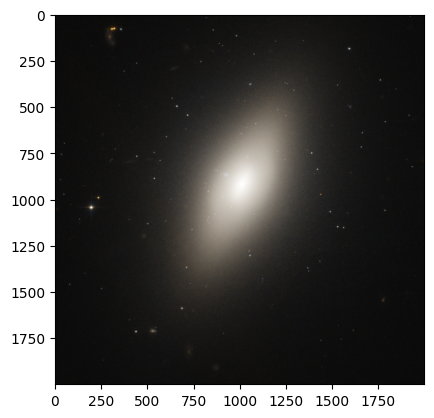

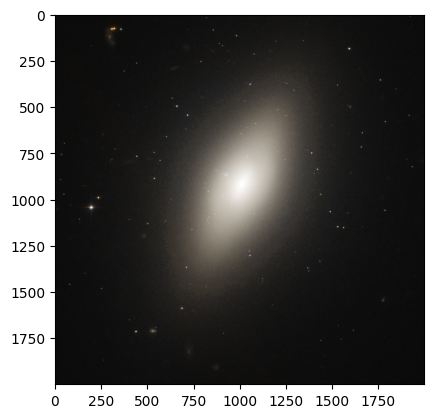

SSIM value:  0.9413684151122023
Selecive SSIM value:  tensor(0.6906)


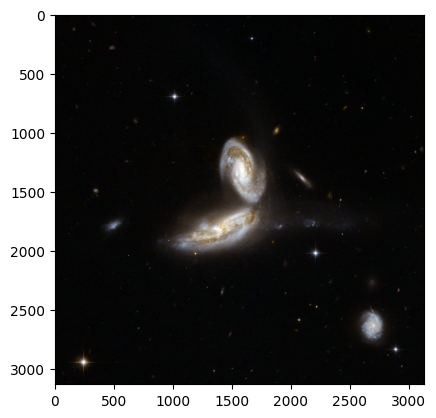

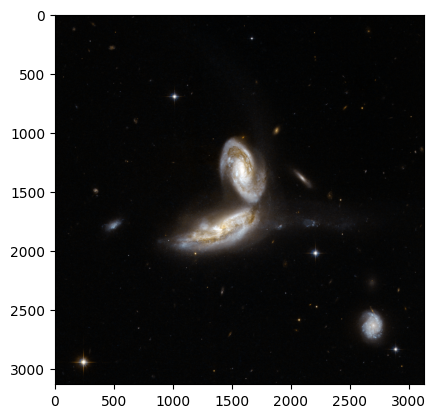

SSIM value:  0.9835242532850069
Selecive SSIM value:  tensor(0.7597)


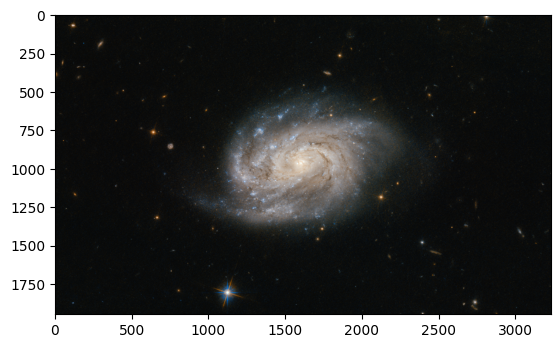

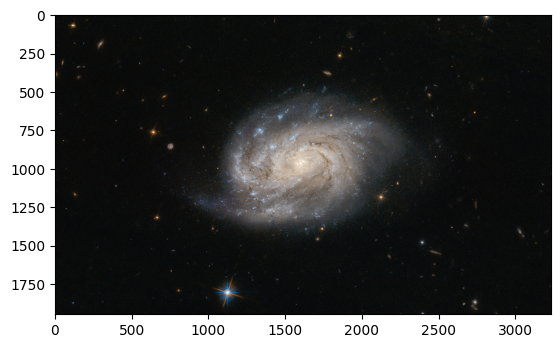

SSIM value:  0.9479052591563158
Selecive SSIM value:  tensor(0.6515)


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


In [ ]:
# compare ssim values

ind = 0

ssim_vals_full = []
ssim_vals_selected = []

for filename in glob.glob('/home/julia/*.tif'):
    # load image
    im=Image.open(filename)
    # convert image to numpy array
    imarray = np.array(im)
    
    # create array that has brightness value for each pixel 
    rgb_array = np.sqrt(0.299*imarray[:,:,0]*imarray[:,:,0] + 0.587*imarray[:,:,1]*imarray[:,:,1] + 0.114*imarray[:,:,2]*imarray[:,:,2])
    data = rgb_array.flatten()
    data = data.reshape(-1,1)
    kmeans = KMeans(n_clusters=3, n_init=10)
    kmeans.fit(data)
    df = pd.DataFrame({'brightness': rgb_array.flatten(),
                           'label': kmeans.labels_})
    
    background_label = df.loc[df['brightness'].idxmin()]['label']
    data = data.reshape(rgb_array.shape)
    labels = kmeans.labels_.reshape(rgb_array.shape[0],rgb_array.shape[1])
    background_array = 1 * (labels == background_label)
    background_array = background_array.reshape(background_array.shape[0], background_array.shape[1], 1)
    detailed_array = 1*(labels != background_label)
    detailed_array = detailed_array.reshape(detailed_array.shape[0], detailed_array.shape[1], 1)
    weighted_array = detailed_array*np.ones((detailed_array.shape[0], detailed_array.shape[1], 3))

    # create sharpened image in detailed areas 
    #im = Image.fromarray(np.uint8(imarray * 255) , 'L')
    #imarray = np.array(im)

    enhancer = ImageEnhance.Sharpness(im)
    factor = 5
    im_sharpened = enhancer.enhance(factor)
    sharpened = np.array(im_sharpened) * detailed_array + imarray * background_array
    #sharpened = unsharp_mask(imarray) * detailed_array + imarray * background_array

    # calculate different ssim scores
    ssim_val_selected = sssim_func(make_tensor(imarray), 
                             make_tensor(sharpened), 
                             val_range=255, 
                             weighted_array=make_tensor(weighted_array))
    ssim_val = ssim(imarray, sharpened, data_range=sharpened.max()-sharpened.min(), channel_axis=2)
    
    if ind in [23, 95, 123]:
        plt.figure()
        plt.imshow(imarray)
        plt.show()
        plt.figure()
        plt.imshow(sharpened)
        plt.show()

        print("SSIM value: ", ssim_val)
        print("Selecive SSIM value: ", ssim_val_selected)

        
    ssim_vals_full.append(ssim_val)
    ssim_vals_selected.append(ssim_val_selected)
    
    ind += 1

#print("Comparison color images:")
#print("Max SSIM difference: ", np.max(np.array(ssim_vals_full)-np.array(ssim_vals_selected)))
#print("Mean SSIM difference: ", np.mean(np.array(ssim_vals_full)-np.array(ssim_vals_selected)))

print("Distribution of SSIM values:")
print("Max SSIM value: ", np.max(ssim_vals_full))
print("Min SSIM value: ", np.min(ssim_vals_full))
print("Mean SSIM value: ", np.mean(ssim_vals_full))

print("Distribution of SSSIM values:")
print("Max SSSIM value: ", np.max(ssim_vals_selected))
print("Min SSSIM value: ", np.min(ssim_vals_selected))
print("Mean SSSIM value: ", np.mean(ssim_vals_selected))

plt.figure()
plt.hist(ssim_vals_full)
plt.title("Histogram of SSIM index values ")

plt.figure()
plt.hist(ssim_vals_selected)
plt.title("Histogram of SSSIM index values")


In [121]:
# save values in csv files
ssim_sharpened_df = pd.DataFrame(ssim_vals_full)
ssim_sharpened_df.to_csv('ssim_sharpened.csv') 
sssim_sharpened_df = pd.DataFrame(ssim_vals_selected)
sssim_sharpened_df.to_csv('sssim_sharpened.csv') 

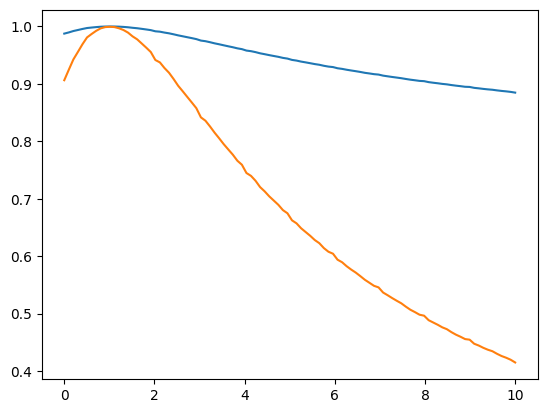

In [4]:
filename = '/home/julia/temp/potw2303a.tif'

ssim_vals = []
sssim_vals = []

#sharpness = np.linspace(0,7,100)
sharpness = np.linspace(0,10,100)

# load image
im=Image.open(filename)
# convert image to numpy array
imarray = np.array(im)

# create array that has brightness value for each pixel 
rgb_array = np.sqrt(0.299*imarray[:,:,0]*imarray[:,:,0] + 0.587*imarray[:,:,1]*imarray[:,:,1] + 0.114*imarray[:,:,2]*imarray[:,:,2])
data = rgb_array.flatten()
data = data.reshape(-1,1)
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(data)
df = pd.DataFrame({'brightness': rgb_array.flatten(),
                   'label': kmeans.labels_})
    
background_label = df.loc[df['brightness'].idxmin()]['label']
data = data.reshape(rgb_array.shape)
labels = kmeans.labels_.reshape(rgb_array.shape[0],rgb_array.shape[1])
background_array = 1 * (labels == background_label)
background_array = background_array.reshape(background_array.shape[0], background_array.shape[1], 1)
detailed_array = 1*(labels != background_label)
detailed_array = detailed_array.reshape(detailed_array.shape[0], detailed_array.shape[1], 1)
weighted_array = detailed_array*np.ones((detailed_array.shape[0], detailed_array.shape[1], 3))

#im = Image.fromarray(np.uint8(imarray * 255) , 'L')
#imarray = np.array(im)
enhancer = ImageEnhance.Sharpness(im)

for s in sharpness:
    #sharpened = unsharp_mask(imarray, amount=s) * detailed_array + imarray * background_array
    factor = s
    im_sharpened = enhancer.enhance(factor)
    sharpened = np.array(im_sharpened) * detailed_array + imarray * background_array

    # calculate different ssim scores
    ssim_val_selected = sssim_func(make_tensor(imarray), 
                             make_tensor(sharpened), 
                             val_range=255, 
                             weighted_array=make_tensor(weighted_array))
    ssim_val = ssim(imarray, sharpened, data_range=sharpened.max()-sharpened.min(), channel_axis=2)
    
    sssim_vals.append(ssim_val_selected)
    ssim_vals.append(ssim_val)


plt.plot(sharpness, ssim_vals)
plt.plot(sharpness, sssim_vals)

# save values in csv files
ssim_sharpened_example_df = pd.DataFrame(ssim_vals)
ssim_sharpened_example_df.to_csv('ssim_sharp_exp.csv') 
sssim_sharpened_example_df = pd.DataFrame(sssim_vals)
sssim_sharpened_example_df.to_csv('sssim_sharp_exp.csv') 

### Adding Pixel Values

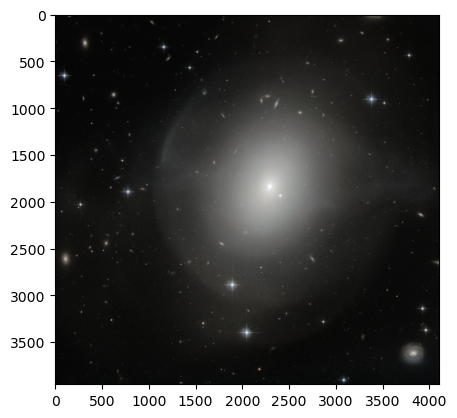

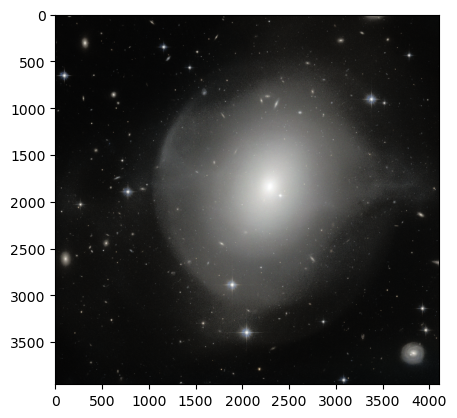

SSIM value:  0.7805457633940646
Selecive SSIM value:  tensor(0.4220)


In [ ]:
# compare ssim values

ind = 0

random.seed(23)

ssim_vals_full = []
ssim_vals_selected = []

for filename in glob.glob('/Users/julianetzel/Desktop/data set/*.tif'):
    # load image
    im=Image.open(filename)
    # convert image to numpy array
    imarray = np.array(im)
    
    # create array that has brightness value for each pixel 
    rgb_array = np.sqrt(0.299*imarray[:,:,0]*imarray[:,:,0] + 0.587*imarray[:,:,1]*imarray[:,:,1] + 0.114*imarray[:,:,2]*imarray[:,:,2])
    data = rgb_array.flatten()
    data = data.reshape(-1,1)
    kmeans = KMeans(n_clusters=3, n_init=10)
    kmeans.fit(data)
    df = pd.DataFrame({'brightness': rgb_array.flatten(),
                           'label': kmeans.labels_})
    
    background_label = df.loc[df['brightness'].idxmin()]['label']
    data = data.reshape(rgb_array.shape)
    labels = kmeans.labels_.reshape(rgb_array.shape[0],rgb_array.shape[1])
    background_array = 1 * (labels == background_label)
    background_array = background_array.reshape(background_array.shape[0], background_array.shape[1], 1)
    detailed_array = 1*(labels != background_label)
    detailed_array = detailed_array.reshape(detailed_array.shape[0], detailed_array.shape[1], 1)
    weighted_array = detailed_array*np.ones((detailed_array.shape[0], detailed_array.shape[1], 3))

    # create modified image in detailed areas 
    modified_array = (np.random.randint(low=0, 
                                        high=50, 
                                        size=weighted_array.shape) 
                      + imarray) * detailed_array + imarray * background_array
    modified_array[modified_array > 255] = 255

    # calculate different ssim scores
    ssim_val_selected = sssim_func(make_tensor(imarray), 
                             make_tensor(modified_array), 
                             val_range=255, 
                             weighted_array=make_tensor(weighted_array))
    ssim_val = ssim(imarray, modified_array, data_range=modified_array.max()-modified_array.min(), channel_axis=2)
    
    if ind in [23, 95, 123]:
        plt.figure()
        plt.imshow(imarray)
        plt.show()
        plt.figure()
        plt.imshow(modified_array)
        plt.show()

        print("SSIM value: ", ssim_val)
        print("Selecive SSIM value: ", ssim_val_selected)

        
    ssim_vals_full.append(ssim_val)
    ssim_vals_selected.append(ssim_val_selected)
    
    ind += 1

print("Comparison color images:")
print("Max SSIM difference: ", np.max(np.array(ssim_vals_full)-np.array(ssim_vals_selected)))
print("Mean SSIM difference: ", np.mean(np.array(ssim_vals_full)-np.array(ssim_vals_selected)))

print("Distribution of SSIM values:")
print("Max SSIM value: ", np.max(ssim_vals_full))
print("Min SSIM value: ", np.min(ssim_vals_full))
print("Mean SSIM value: ", np.mean(ssim_vals_full))

print("Distribution of SSSIM values:")
print("Max SSSIM value: ", np.max(ssim_vals_selected))
print("Min SSSIM value: ", np.min(ssim_vals_selected))
print("Mean SSSIM value: ", np.mean(ssim_vals_selected))

plt.figure()
plt.hist(ssim_vals_full)
plt.title("Histogram of SSIM index values ")

plt.figure()
plt.hist(ssim_vals_selected)
plt.title("Histogram of SSSIM index values")


In [ ]:
# save values in csv files
ssim_added_vals_df = pd.DataFrame(ssim_vals_full)
ssim_added_vals_df.to_csv('ssim_added_vals.csv') 
sssim_added_vals_df = pd.DataFrame(ssim_vals_selected)
sssim_added_vals_df.to_csv('sssim_added_vals.csv') 

In [ ]:
filename = '/Users/julianetzel/Desktop/data set/potw2303a.tif'

ssim_vals = []
sssim_vals = []

pixel_threshold = np.linspace(10,255,50)

# load image
im=Image.open(filename)
# convert image to numpy array
imarray = np.array(im)

# create array that has brightness value for each pixel 
rgb_array = np.sqrt(0.299*imarray[:,:,0]*imarray[:,:,0] + 0.587*imarray[:,:,1]*imarray[:,:,1] + 0.114*imarray[:,:,2]*imarray[:,:,2])
data = rgb_array.flatten()
data = data.reshape(-1,1)
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(data)
df = pd.DataFrame({'brightness': rgb_array.flatten(),
                   'label': kmeans.labels_})
    
background_label = df.loc[df['brightness'].idxmin()]['label']
data = data.reshape(rgb_array.shape)
labels = kmeans.labels_.reshape(rgb_array.shape[0],rgb_array.shape[1])
background_array = 1 * (labels == background_label)
background_array = background_array.reshape(background_array.shape[0], background_array.shape[1], 1)
detailed_array = 1*(labels != background_label)
detailed_array = detailed_array.reshape(detailed_array.shape[0], detailed_array.shape[1], 1)
weighted_array = detailed_array*np.ones((detailed_array.shape[0], detailed_array.shape[1], 3))

for pixel in pixel_threshold:
    modified_array = (np.random.randint(low=int(pixel)-10, 
                                        high=int(pixel), 
                                        size=weighted_array.shape) 
                      + imarray) * detailed_array + imarray * background_array
    modified_array[modified_array > 255] = 255

    # calculate different ssim scores
    ssim_val_selected = sssim_func(make_tensor(imarray), 
                             make_tensor(modified_array), 
                             val_range=255, 
                             weighted_array=make_tensor(weighted_array))
    ssim_val = ssim(imarray, modified_array, data_range=modified_array.max()-modified_array.min(), channel_axis=2)
    
    sssim_vals.append(ssim_val_selected)
    ssim_vals.append(ssim_val)


plt.plot(pixel_threshold, ssim_vals)
plt.plot(pixel_threshold, sssim_vals)

# save values in csv files
ssim_added_example_df = pd.DataFrame(ssim_vals)
ssim_added_example_df.to_csv('ssim_added_exp.csv') 
sssim_added_example_df = pd.DataFrame(sssim_vals)
sssim_added_example_df.to_csv('sssim_added_exp.csv')



## Background Detection on RGB Data Set - Mean Value Threshold

### Showing portion of background detected


In [4]:
ind = 0
background_percentage = []

for filename in glob.glob('/home/julia/temp/*.tif'):
    print(ind)
    
    # load image
    im=Image.open(filename)
    # convert image to numpy array
    imarray = np.array(im)
    
    # segment image by creating np.array that has 1s wherever 
    # at least one of RGB values is above image pixel mean for detailed are
    # and creating np.array that has 1s whereever all RGB values are below threshold
    boolean_array = np.all((imarray > imarray.mean()), axis=2, keepdims = True)
    background_array = np.any((boolean_array == False), axis=2, keepdims=True)
    # create weighted array in right shape
    weighted_array = boolean_array*np.ones((boolean_array.shape[0], boolean_array.shape[1], 3))

    background_portion = np.count_nonzero(background_array)
    detailed_portion = np.count_nonzero(weighted_array)
    background_percentage.append(background_portion/(background_portion+detailed_portion))
    ind += 1
    
print(np.mean(background_percentage))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Blurring

In [ ]:
# compare ssim values

ind = 0

example_files = ['potw2303a.tif', 'heic1507h.tif', 'potw2236a.tif']
ssim_vals_full = []
ssim_vals_selected = []

for filename in glob.glob('/Users/julianetzel/Desktop/data set/*.tif'):
    # load image
    im=Image.open(filename)
    # convert image to numpy array
    imarray = np.array(im)
    
    # segment image by creating np.array that has 1s wherever 
    # at least one of RGB values is above image pixel mean for detailed are
    # and creating np.array that has 1s whereever all RGB values are below threshold
    boolean_array = np.all((imarray > imarray.mean()), axis=2, keepdims = True)
    background_array = np.any((boolean_array == False), axis=2, keepdims=True)
    segmented_im = imarray * boolean_array
    background_im = imarray * background_array
    # create weighted array in right shape
    weighted_array = boolean_array*np.ones((boolean_array.shape[0], boolean_array.shape[1], 3))
    
    
    # create blurred image by applying gaussian blur to pixels where at least one RGB value is above threshold
    # and merging it with regular background pixels in areas where all RGB values are below threshold
    blurred = gaussian_filter(imarray, sigma=1) * boolean_array + background_im
    
    # calculate different ssim values
    ssim_val_full = ssim(imarray, blurred, data_range=blurred.max() - blurred.min(), channel_axis=2)
    ssim_vals_full.append(ssim_val_full)
    ssim_val_selected = sssim_func(make_tensor(imarray), 
                                   make_tensor(blurred), 
                                   val_range=255, 
                                   weighted_array=make_tensor(weighted_array))
    ssim_vals_selected.append(ssim_val_selected)

    if ind in [64, 123, 183, 241]:
        plt.figure()
        plt.imshow(imarray)
        plt.show()
        plt.figure()
        plt.imshow(blurred)
        plt.show()

        print("SSIM value: ", ssim_val)
        print("Selecive SSIM value: ", ssim_val_selected)
    
    ind += 1

print("Comparison color images:")
print("Max SSIM difference: ", np.max(np.array(ssim_vals_full)-np.array(ssim_vals_selected)))
print("Mean SSIM difference: ", np.mean(np.array(ssim_vals_full)-np.array(ssim_vals_selected)))

print("Distribution of SSIM values:")
print("Max SSIM value: ", np.max(ssim_vals_full))
print("Min SSIM value: ", np.min(ssim_vals_full))
print("Mean SSIM value: ", np.mean(ssim_vals_full))

print("Distribution of SSSIM values:")
print("Max SSSIM value: ", np.max(ssim_vals_selected))
print("Min SSSIM value: ", np.min(ssim_vals_selected))
print("Mean SSSIM value: ", np.mean(ssim_vals_selected))

plt.figure()
plt.hist(ssim_vals_full)
plt.title("Histogram of SSIM index values ")

plt.figure()
plt.hist(ssim_vals_selected)
plt.title("Histogram of SSSIM index values")

In [ ]:
# save values in csv files
ssim_blurred_df = pd.DataFrame(ssim_vals_full)
ssim_blurred_df.to_csv('ssim_blurred_mean_val.csv') 
sssim_blurred_df = pd.DataFrame(ssim_vals_selected)
sssim_blurred_df.to_csv('sssim_blurred_mean_val.csv') 

In [ ]:
filename = '/Users/julianetzel/Desktop/data set/potw2303a.tif'

ssim_vals = []
sssim_vals = []

gaussian_blur = np.linspace(0,2.5,100)

# load image
im=Image.open(filename)
# convert image to numpy array
imarray = np.array(im)

# segment image by creating np.array that has 1s wherever 
# at least one of RGB values is above image pixel mean for detailed are
# and creating np.array that has 1s whereever all RGB values are below threshold
boolean_array = np.all((imarray > imarray.mean()), axis=2, keepdims = True)
background_array = np.any((boolean_array == False), axis=2, keepdims=True)
segmented_im = imarray * boolean_array
background_im = imarray * background_array
# create weighted array in right shape
weighted_array = boolean_array*np.ones((boolean_array.shape[0], boolean_array.shape[1], 3))
    
for blur in gaussian_blur:
    #create blurred image in detailed areas 
    blurred = gaussian_filter(imarray, sigma=blur) * boolean_array + imarray * background_array
    # calculate different ssim scores
    ssim_val_selected = sssim_func(make_tensor(imarray), 
                                   make_tensor(blurred), 
                                   val_range=255, 
                                   weighted_array=make_tensor(weighted_array))
    ssim_val = ssim(imarray, blurred, data_range=blurred.max()-blurred.min(), channel_axis=2)

    sssim_vals.append(ssim_val_selected)
    ssim_vals.append(ssim_val)

plt.plot(gaussian_blur, ssim_vals)
plt.plot(gaussian_blur, sssim_vals)

# save values in csv files
ssim_blurred_df = pd.DataFrame(ssim_vals)
ssim_blurred_df.to_csv('ssim_blurred_mean_exp_val.csv') 
sssim_blurred_df = pd.DataFrame(sssim_vals)
sssim_blurred_df.to_csv('sssim_blurred_exp_mean_val.csv') 


### Sharpening

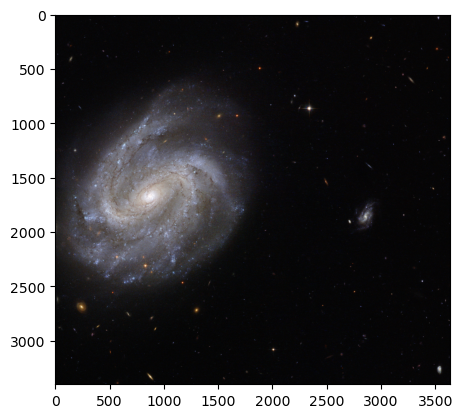

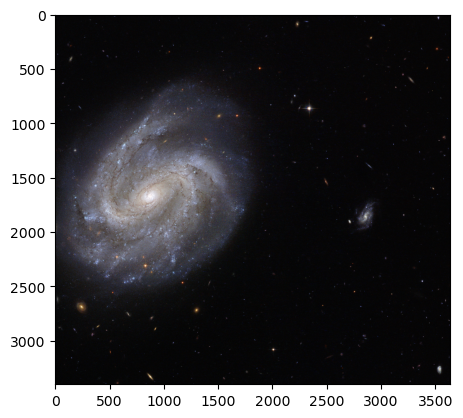

SSIM value:  0.9148679416455341
Selecive SSIM value:  tensor(0.6115)


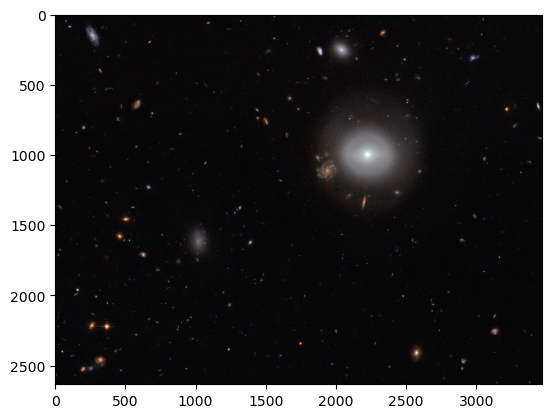

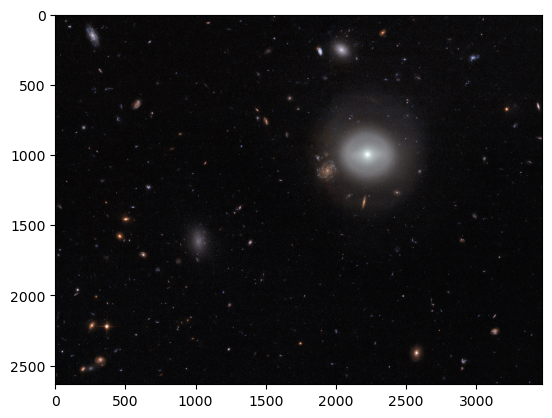

SSIM value:  0.7694161894690676
Selecive SSIM value:  tensor(0.6538)


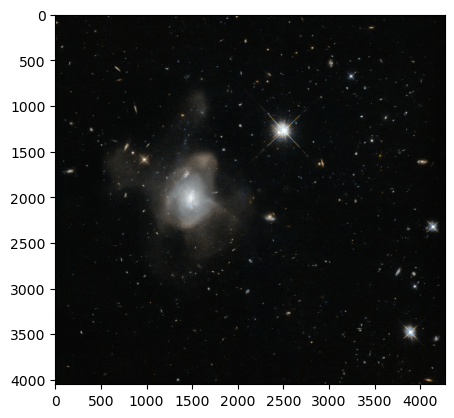

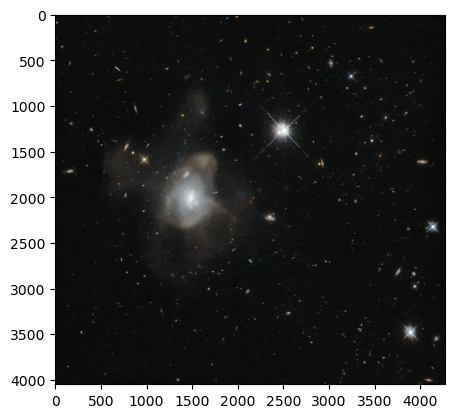

SSIM value:  0.6449808235618376
Selecive SSIM value:  tensor(0.6073)


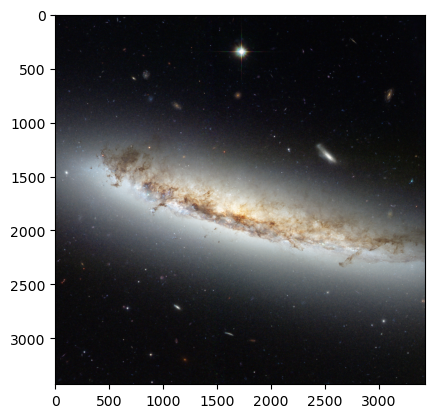

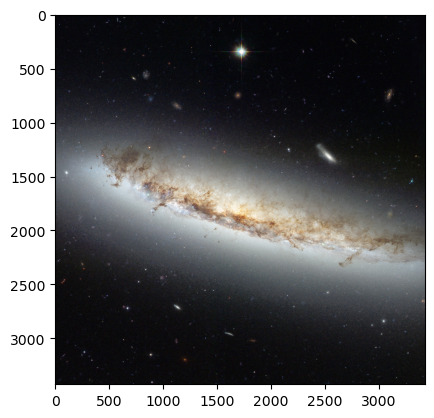

SSIM value:  0.8957519648119279
Selecive SSIM value:  tensor(0.7113)
Comparison color images:
Max SSIM difference:  nan
Mean SSIM difference:  nan
Distribution of SSIM values:
Max SSIM value:  1.0
Min SSIM value:  0.6449808235618376
Mean SSIM value:  0.8935266588517573
Distribution of SSSIM values:
Max SSSIM value:  nan
Min SSSIM value:  nan
Mean SSSIM value:  nan


Text(0.5, 1.0, 'Histogram of SSSIM index values')

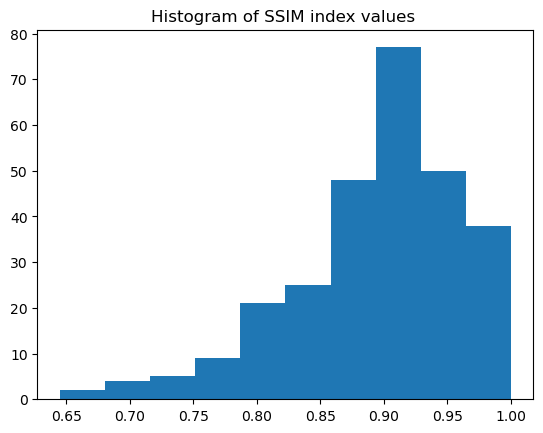

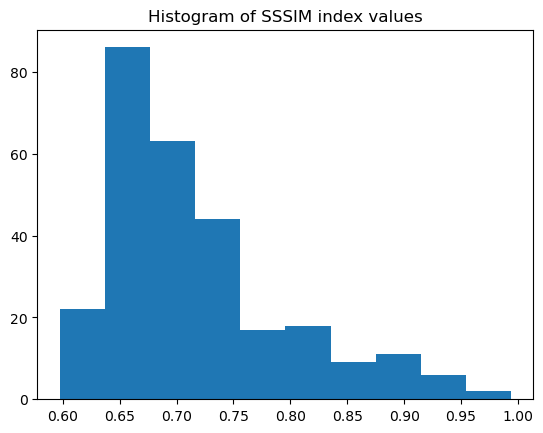

In [7]:
# compare ssim values

ind = 0

ssim_vals_full = []
ssim_vals_selected = []

for filename in glob.glob('/Users/julianetzel/Desktop/data set/*.tif'):
    # load image
    im=Image.open(filename)
    # convert image to numpy array
    imarray = np.array(im)
    
    # segment image by creating np.array that has 1s wherever 
    # at least one of RGB values is above image pixel mean for detailed are
    # and creating np.array that has 1s whereever all RGB values are below threshold
    boolean_array = np.all((imarray > imarray.mean()), axis=2, keepdims = True)
    background_array = np.any((boolean_array == False), axis=2, keepdims=True)
    segmented_im = imarray * boolean_array
    background_im = imarray * background_array
    # create weighted array in right shape
    weighted_array = boolean_array*np.ones((boolean_array.shape[0], boolean_array.shape[1], 3))
    
    # create sharpened image
    #sharpened = unsharp_mask(imarray) * boolean_array + imarray * background_array
    enhancer = ImageEnhance.Sharpness(im)
    factor = 5
    im_sharpened = enhancer.enhance(factor)
    sharpened = np.array(im_sharpened) * detailed_array + imarray * background_array

    # calculate different ssim values
    ssim_val_full = ssim(imarray, sharpened, data_range=sharpened.max() - sharpened.min(), channel_axis=2)
    ssim_vals_full.append(ssim_val_full)
    ssim_val_selected = sssim_func(make_tensor(imarray), 
                                   make_tensor(sharpened), 
                                   val_range=255, 
                                   weighted_array=make_tensor(weighted_array))
    ssim_vals_selected.append(ssim_val_selected)

    if ind in [64, 123, 183, 241]:
        plt.figure()
        plt.imshow(imarray)
        plt.show()
        plt.figure()
        plt.imshow(sharpened)
        plt.show()

        print("SSIM value: ", ssim_val_full)
        print("Selecive SSIM value: ", ssim_val_selected)
    
    ind += 1

print("Comparison color images:")
print("Max SSIM difference: ", np.max(np.array(ssim_vals_full)-np.array(ssim_vals_selected)))
print("Mean SSIM difference: ", np.mean(np.array(ssim_vals_full)-np.array(ssim_vals_selected)))

print("Distribution of SSIM values:")
print("Max SSIM value: ", np.max(ssim_vals_full))
print("Min SSIM value: ", np.min(ssim_vals_full))
print("Mean SSIM value: ", np.mean(ssim_vals_full))

print("Distribution of SSSIM values:")
print("Max SSSIM value: ", np.max(ssim_vals_selected))
print("Min SSSIM value: ", np.min(ssim_vals_selected))
print("Mean SSSIM value: ", np.mean(ssim_vals_selected))

plt.figure()
plt.hist(ssim_vals_full)
plt.title("Histogram of SSIM index values ")

plt.figure()
plt.hist(ssim_vals_selected)
plt.title("Histogram of SSSIM index values")

In [8]:
# save values in csv files
ssim_sharpened_df = pd.DataFrame(ssim_vals_full)
ssim_sharpened_df.to_csv('ssim_sharpened_mean_val.csv') 
sssim_sharpened_df = pd.DataFrame(ssim_vals_selected)
sssim_sharpened_df.to_csv('sssim_sharpened_mean_val.csv') 

NameError: name 'ssim_vals_full' is not defined

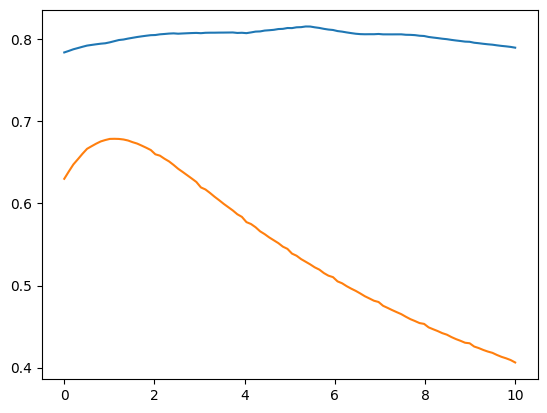

In [5]:
filename = '/home/julia/temp/potw2303a.tif'

ssim_vals = []
sssim_vals = []

#sharpness = np.linspace(0,7,100)
sharpness = np.linspace(1,10,100)


# load image
im=Image.open(filename)
# convert image to numpy array
imarray = np.array(im)
    
# segment image by creating np.array that has 1s wherever 
# at least one of RGB values is above image pixel mean for detailed are
# and creating np.array that has 1s whereever all RGB values are below threshold
boolean_array = np.all((imarray > imarray.mean()), axis=2, keepdims = True)
background_array = np.any((boolean_array == False), axis=2, keepdims=True)
segmented_im = imarray * boolean_array
background_im = imarray * background_array
# create weighted array in right shape
weighted_array = boolean_array*np.ones((boolean_array.shape[0], boolean_array.shape[1], 3))

#im = Image.fromarray(np.uint8(imarray * 255) , 'L')
#imarray = np.array(im)
enhancer = ImageEnhance.Sharpness(im)  
    
for s in sharpness:
    #create sharpened image in detailed areas 
    #sharpened = unsharp_mask(imarray, amount=s) * boolean_array + imarray * background_array
    factor = s
    im_sharpened = enhancer.enhance(factor)
    sharpened = np.array(im_sharpened) * detailed_array + imarray * background_array
      
    # calculate different ssim scores
    ssim_val_selected = sssim_func(make_tensor(imarray), 
                                   make_tensor(sharpened), 
                                   val_range=255, 
                                   weighted_array=make_tensor(weighted_array))
    ssim_val = ssim(imarray, sharpened, data_range=sharpened.max()-sharpened.min(), channel_axis=2)

    sssim_vals.append(ssim_val_selected)
    ssim_vals.append(ssim_val)


plt.plot(sharpness, ssim_vals)
plt.plot(sharpness, sssim_vals)

# save values in csv files
ssim_sharpened_df = pd.DataFrame(ssim_vals)
ssim_sharpened_df.to_csv('ssim_sharpened_exp_mean_val.csv') 
sssim_sharpened_df = pd.DataFrame(ssim_vals_selected)
sssim_sharpened_df.to_csv('sssim_sharpened_exp_mean_val.csv') 


In [7]:
ssim_sharpened_df = pd.DataFrame(ssim_vals)
ssim_sharpened_df.to_csv('ssim_sharpened_exp_mean_val.csv') 
sssim_sharpened_df = pd.DataFrame(sssim_vals)
sssim_sharpened_df.to_csv('sssim_sharpened_exp_mean_val.csv') 

### Adding pixel values

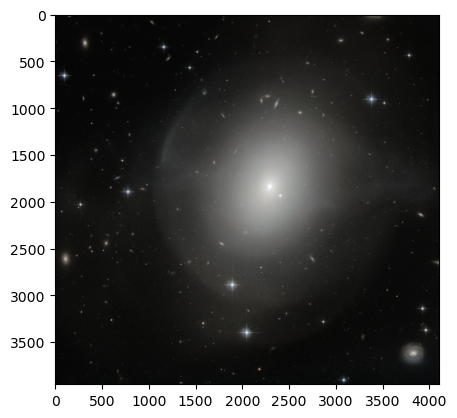

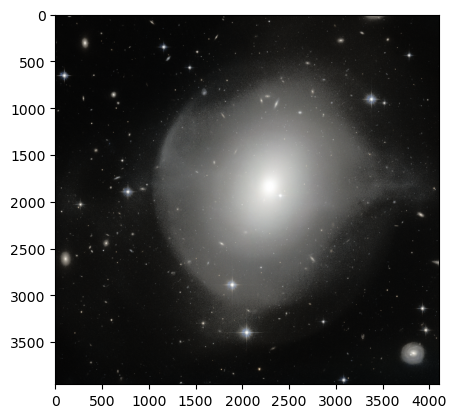

SSIM value:  0.8224984862507241
Selecive SSIM value:  tensor(0.6096)


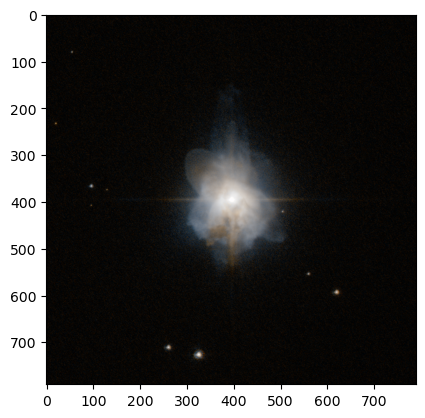

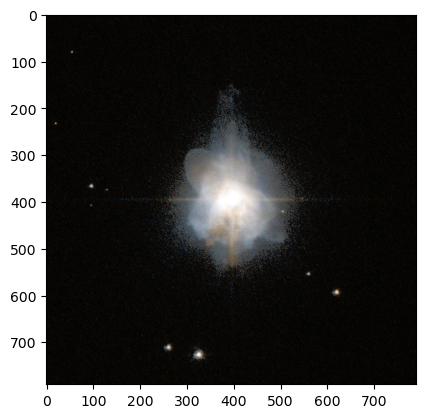

SSIM value:  0.9227730180696421
Selecive SSIM value:  tensor(0.5832)


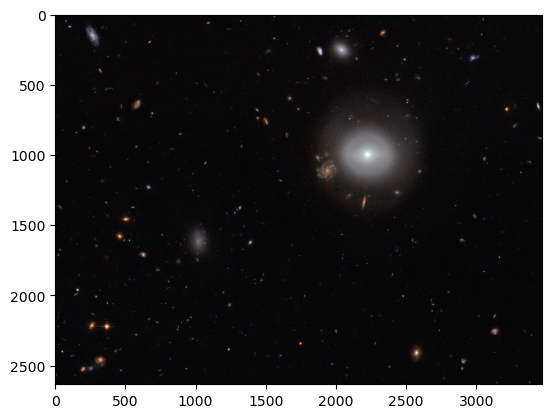

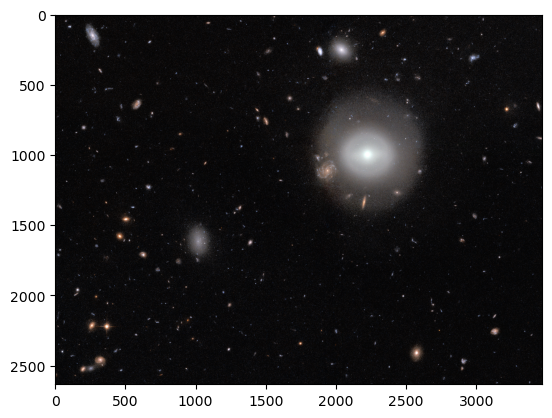

SSIM value:  0.6795343882358525
Selecive SSIM value:  tensor(0.5871)
Comparison color images:
Max SSIM difference:  nan
Mean SSIM difference:  nan
Distribution of SSIM values:
Max SSIM value:  1.0
Min SSIM value:  0.3507390880172215
Mean SSIM value:  0.8271817484246269
Distribution of SSSIM values:
Max SSSIM value:  nan
Min SSSIM value:  nan
Mean SSSIM value:  nan


Text(0.5, 1.0, 'Histogram of SSSIM index values')

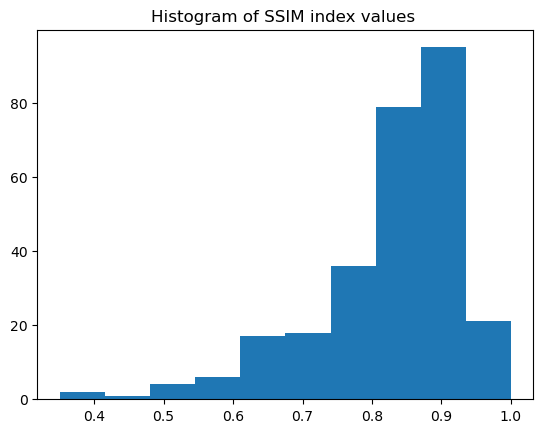

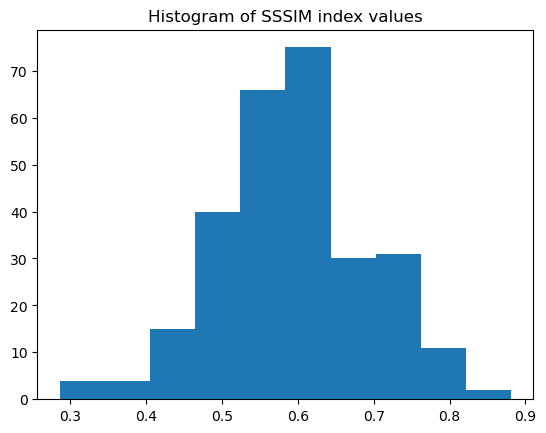

In [10]:
# compare ssim values

ind = 0

random.seed(23)

ssim_vals_full = []
ssim_vals_selected = []

for filename in glob.glob('/Users/julianetzel/Desktop/data set/*.tif'):
    # load image
    im=Image.open(filename)
    # convert image to numpy array
    imarray = np.array(im)
    
    # segment image by creating np.array that has 1s wherever 
    # at least one of RGB values is above image pixel mean for detailed are
    # and creating np.array that has 1s whereever all RGB values are below threshold
    boolean_array = np.all((imarray > imarray.mean()), axis=2, keepdims = True)
    background_array = np.any((boolean_array == False), axis=2, keepdims=True)
    segmented_im = imarray * boolean_array
    background_im = imarray * background_array
    # create weighted array in right shape
    weighted_array = boolean_array*np.ones((boolean_array.shape[0], boolean_array.shape[1], 3))
    
    # create modified image in detailed areas 
    modified_array = (np.random.randint(low=0, 
                                        high=50, 
                                        size=weighted_array.shape) 
                      + imarray) * boolean_array + imarray * background_array
    modified_array[modified_array > 255] = 255

    # calculate different ssim scores
    ssim_val_selected = sssim_func(make_tensor(imarray), 
                             make_tensor(modified_array), 
                             val_range=255, 
                             weighted_array=make_tensor(weighted_array))
    ssim_val = ssim(imarray, modified_array, data_range=modified_array.max()-modified_array.min(), channel_axis=2)
    
    if ind in [23, 95, 123]:
        plt.figure()
        plt.imshow(imarray)
        plt.show()
        plt.figure()
        plt.imshow(modified_array)
        plt.show()

        print("SSIM value: ", ssim_val)
        print("Selecive SSIM value: ", ssim_val_selected)

        
    ssim_vals_full.append(ssim_val)
    ssim_vals_selected.append(ssim_val_selected)
    
    ind += 1
    
print("Comparison color images:")
print("Max SSIM difference: ", np.max(np.array(ssim_vals_full)-np.array(ssim_vals_selected)))
print("Mean SSIM difference: ", np.mean(np.array(ssim_vals_full)-np.array(ssim_vals_selected)))

print("Distribution of SSIM values:")
print("Max SSIM value: ", np.max(ssim_vals_full))
print("Min SSIM value: ", np.min(ssim_vals_full))
print("Mean SSIM value: ", np.mean(ssim_vals_full))

print("Distribution of SSSIM values:")
print("Max SSSIM value: ", np.max(ssim_vals_selected))
print("Min SSSIM value: ", np.min(ssim_vals_selected))
print("Mean SSSIM value: ", np.mean(ssim_vals_selected))

plt.figure()
plt.hist(ssim_vals_full)
plt.title("Histogram of SSIM index values ")

plt.figure()
plt.hist(ssim_vals_selected)
plt.title("Histogram of SSSIM index values")


In [11]:
# save values in csv files
ssim_added_vals_df = pd.DataFrame(ssim_vals_full)
ssim_added_vals_df.to_csv('ssim_added_vals_mean_val.csv') 
sssim_added_vals_df = pd.DataFrame(ssim_vals_selected)
sssim_added_vals_df.to_csv('sssim_added_vals_mean_val.csv') 

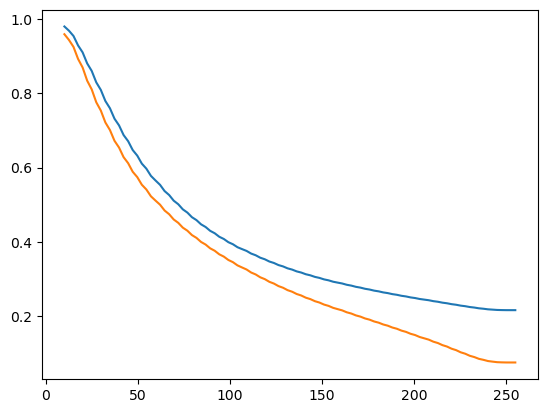

In [12]:
filename = '/Users/julianetzel/Desktop/data set/potw2303a.tif'

pixel_threshold = np.linspace(10,255,100)

ssim_vals = []
sssim_vals = []

# load image
im=Image.open(filename)
# convert image to numpy array
imarray = np.array(im)
# segment image by creating np.array that has 1s wherever 
# at least one of RGB values is above image pixel mean for detailed are
# and creating np.array that has 1s whereever all RGB values are below threshold
boolean_array = np.all((imarray > imarray.mean()), axis=2, keepdims = True)
background_array = np.any((boolean_array == False), axis=2, keepdims=True)
segmented_im = imarray * boolean_array
background_im = imarray * background_array
# create weighted array in right shape
weighted_array = boolean_array*np.ones((boolean_array.shape[0], boolean_array.shape[1], 3))
    
for pixel in pixel_threshold:
    # create modified image in detailed areas 
    modified_array = (np.random.randint(low=int(pixel)-10, 
                                        high=int(pixel), 
                                        size=weighted_array.shape) 
                      + imarray) * boolean_array + imarray * background_array
    modified_array[modified_array > 255] = 255

    # calculate different ssim scores
    ssim_val_selected = sssim_func(make_tensor(imarray), 
                             make_tensor(modified_array), 
                             val_range=255, 
                             weighted_array=make_tensor(weighted_array))
    ssim_val = ssim(imarray, modified_array, data_range=modified_array.max()-modified_array.min(), channel_axis=2)
    sssim_vals.append(ssim_val_selected)
    ssim_vals.append(ssim_val)


plt.plot(pixel_threshold, ssim_vals)
plt.plot(pixel_threshold, sssim_vals)

# save values in csv files
ssim_added_vals_df = pd.DataFrame(ssim_vals_full)
ssim_added_vals_df.to_csv('ssim_added_vals__exp_mean_val.csv') 
sssim_added_vals_df = pd.DataFrame(ssim_vals_selected)
sssim_added_vals_df.to_csv('sssim_added_vals_exp_mean_val.csv') 
